In [1]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import other libraries when needed 

## 1. DATA PROCESSING

In [2]:
# Load raw data
df = pd.read_parquet("dataDumper.parquet")

In [3]:
df.head()

,Time_utc,VehicleName,VehicleType,Pressure_Pa_1,Pressure_Pa_2,Pressure_Pa_3,Pressure_Pa_4,Pressure_Pa_5,Pressure_Pa_6,Temperature_K_1,...,Altitude_m,Speed_mps,epsilonX,epsilonY,epsilonZ,epsilonSpeed,AtmosphericPressure_Pa,dt_s,dd_m,RatioPayload
0,2023-01-01 00:00:00.328,C-132,Dumper,993010.933333,1.003995e+06,856000.0,798005.466667,819994.533333,864994.533333,346.15,...,4581.000000,9.003,6.207,6.312,23.000000,0.0,59002.557667,4.912,41.480140,0.0
1,2023-01-01 00:00:05.338,C-132,Dumper,993177.933329,1.003911e+06,856000.0,798088.966665,819911.033335,864911.033335,346.15,...,4577.600098,9.003,6.393,6.797,27.600000,0.0,59028.296172,5.010,45.952211,0.0
2,2023-01-01 00:00:10.331,C-132,Dumper,993344.366669,1.003828e+06,856000.0,798172.183334,819827.816666,864827.816666,346.15,...,4573.000000,9.723,6.721,7.631,32.200001,0.0,59064.789917,4.993,47.007842,0.0
3,2023-01-01 00:00:15.325,C-132,Dumper,993510.833331,1.003745e+06,856000.0,798255.416666,819744.583334,864744.583334,346.15,...,4568.600098,9.620,6.361,6.504,23.000000,0.0,59101.596928,4.994,48.700870,0.0
4,2023-01-01 00:00:20.448,C-132,Dumper,993681.600000,1.003659e+06,856000.0,798340.800000,819659.200000,864659.200000,346.15,...,4564.500000,11.318,6.361,7.144,23.000000,0.0,59139.354701,5.123,52.675397,0.0


In [4]:
df.columns

Index(['Time_utc', 'VehicleName', 'VehicleType', 'Pressure_Pa_1',
       'Pressure_Pa_2', 'Pressure_Pa_3', 'Pressure_Pa_4', 'Pressure_Pa_5',
       'Pressure_Pa_6', 'Temperature_K_1', 'Temperature_K_2',
       'Temperature_K_3', 'Temperature_K_4', 'Temperature_K_5',
       'Temperature_K_6', 'ColdPressure_Pa_1', 'ColdPressure_Pa_2',
       'ColdPressure_Pa_3', 'ColdPressure_Pa_4', 'ColdPressure_Pa_5',
       'ColdPressure_Pa_6', 'Latitude_dd', 'Longitude_dd', 'Altitude_m',
       'Speed_mps', 'epsilonX', 'epsilonY', 'epsilonZ', 'epsilonSpeed',
       'AtmosphericPressure_Pa', 'dt_s', 'dd_m', 'RatioPayload'],
      dtype='object')

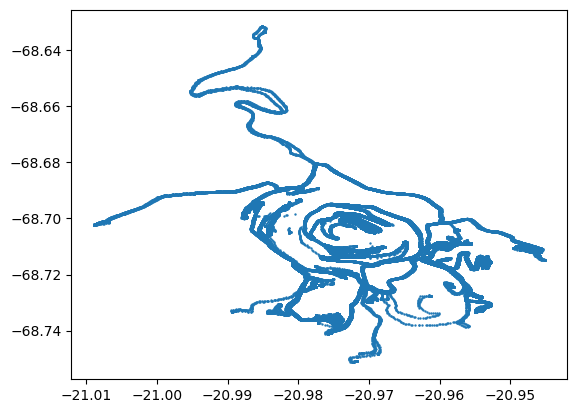

In [5]:
plt.scatter(x = df['Latitude_dd'], y = df['Longitude_dd'], s=0.5)

In [6]:
plot = df[['Longitude_dd','Latitude_dd']]

In [7]:
# Create Segments based on  RatioPayLoad
df[['phaseNb']] = df[['RatioPayload']].diff().abs().cumsum()

In [8]:
#Split the data into loaded trajectories and empty trajectories
segment_list = [data_phase for _, data_phase in df.groupby('phaseNb')]
empty_segment_list = []
load_segment_list = []

for segment in segment_list:
    if segment.RatioPayload.mean() == 0.0:
        empty_segment_list.append(segment)
    elif segment.RatioPayload.mean() == 1.0:
        load_segment_list.append(segment)

In [9]:
print(f'N° of Loaded segments :{len(load_segment_list)}')
print(f'N° of Empty segments :{len(empty_segment_list)}')

N° of Loaded segments :263
N° of Empty segments :263


<Axes: xlabel='Latitude_dd', ylabel='Longitude_dd'>

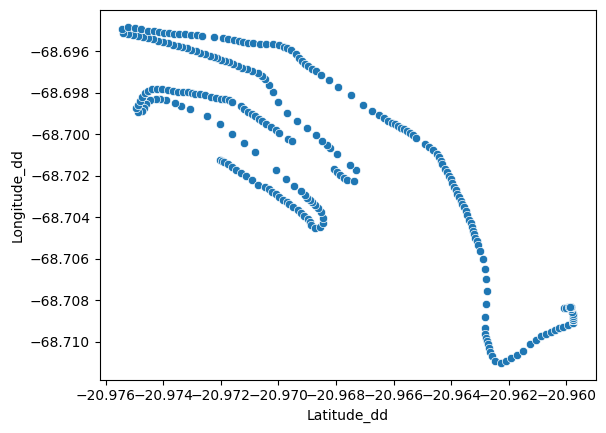

In [10]:
sns.scatterplot(x = load_segment_list[5]['Latitude_dd'],
                y = load_segment_list[5]['Longitude_dd'])

<Axes: xlabel='Latitude_dd', ylabel='Longitude_dd'>

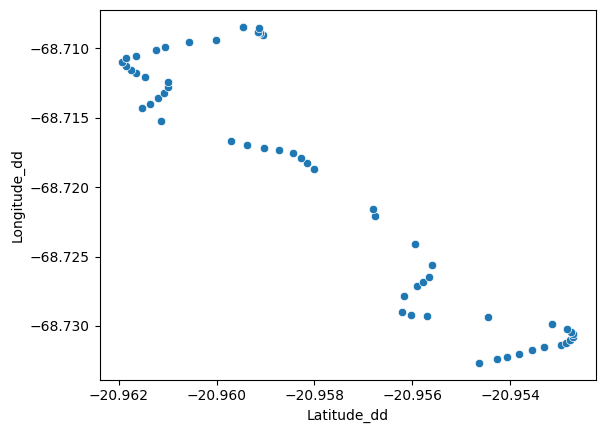

In [11]:
sns.scatterplot(x = load_segment_list[75]['Latitude_dd'],
                y = load_segment_list[75]['Longitude_dd'])

Distance moyenne entre 2 points (dd_m) : 21.15 m


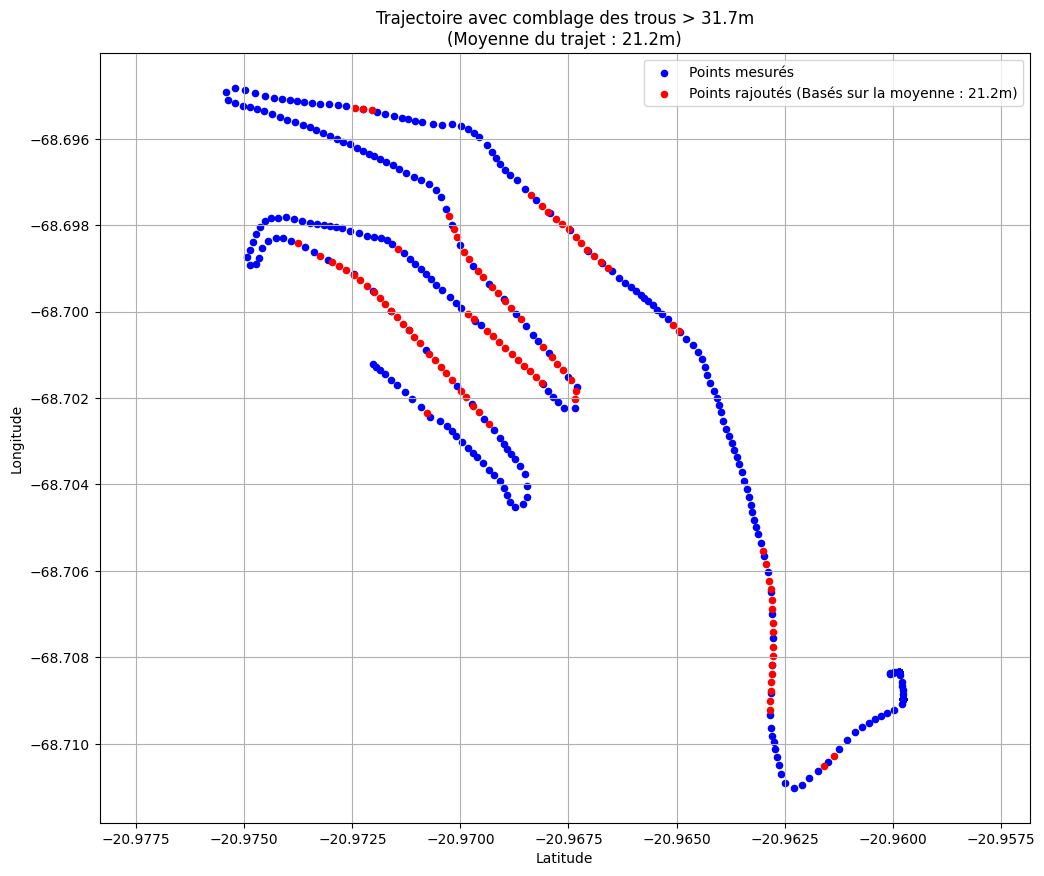

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Chargement du segment
segment = load_segment_list[5].copy().reset_index(drop=True)

# --- Fonction Distance Haversine ---
def haversine_dist(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# 2. CALCUL DES MOYENNES (dd_m et dt_s) SUR TOUT LE TRAJET
distances = []
times = []

# On collecte tous les écarts pour faire la moyenne
for i in range(len(segment) - 1):
    p1 = segment.iloc[i]
    p2 = segment.iloc[i+1]
    
    d = haversine_dist(p1['Latitude_dd'], p1['Longitude_dd'], 
                       p2['Latitude_dd'], p2['Longitude_dd'])
    distances.append(d)
    
    # Calcul du temps si la colonne existe
    if 'Timestamp' in segment.columns:
        t = (p2['Timestamp'] - p1['Timestamp']).total_seconds()
        times.append(t)

# Calcul des moyennes
moyenne_dd_m = np.mean(distances)
print(f"Distance moyenne entre 2 points (dd_m) : {moyenne_dd_m:.2f} m")

if times:
    moyenne_dt_s = np.mean(times)
    print(f"Temps moyen entre 2 points (dt_s) : {moyenne_dt_s:.2f} s")

# 3. INTERPOLATION INTELLIGENTE
new_lats = []
new_lons = []

# Seuil pour dire "C'est un grand écart"
# Si la distance est > 1.5 fois la moyenne, on considère qu'il manque des points
SEUIL_DETECTION = moyenne_dd_m * 1.5 

for i in range(len(segment) - 1):
    p_start = segment.iloc[i]
    p_end = segment.iloc[i+1]
    
    dist_reelle = distances[i] # La distance de ce segment spécifique
    
    # Si l'écart est "grand" par rapport à la moyenne, on remplit
    if dist_reelle > SEUIL_DETECTION:
        
        # On va insérer des points tous les "moyenne_dd_m" mètres
        # On commence à 1x la moyenne
        dist_courante = moyenne_dd_m
        
        while dist_courante < dist_reelle:
            # Position relative (0 à 1)
            ratio = dist_courante / dist_reelle
            
            interp_lat = p_start['Latitude_dd'] + ratio * (p_end['Latitude_dd'] - p_start['Latitude_dd'])
            interp_lon = p_start['Longitude_dd'] + ratio * (p_end['Longitude_dd'] - p_start['Longitude_dd'])
            
            new_lats.append(interp_lat)
            new_lons.append(interp_lon)
            
            # On avance d'un pas moyen
            dist_courante += moyenne_dd_m

# 4. VISUALISATION
plt.figure(figsize=(12, 10))
plt.grid(True)

# Points mesurés (Bleu)
plt.scatter(segment['Latitude_dd'], segment['Longitude_dd'], 
            c='blue', s=20, label='Points mesurés')

# Points interpolés (Rouge)
# On vérifie qu'il y a bien eu des points rajoutés
if len(new_lats) > 0:
    plt.scatter(new_lats, new_lons, 
                c='red', s=20, 
                label=f'Points rajoutés (Basés sur la moyenne : {moyenne_dd_m:.1f}m)')
else:
    print("Aucun écart significatif détecté par rapport à la moyenne.")

plt.title(f"Trajectoire avec comblage des trous > {SEUIL_DETECTION:.1f}m\n(Moyenne du trajet : {moyenne_dd_m:.1f}m)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.axis('equal')
plt.show()

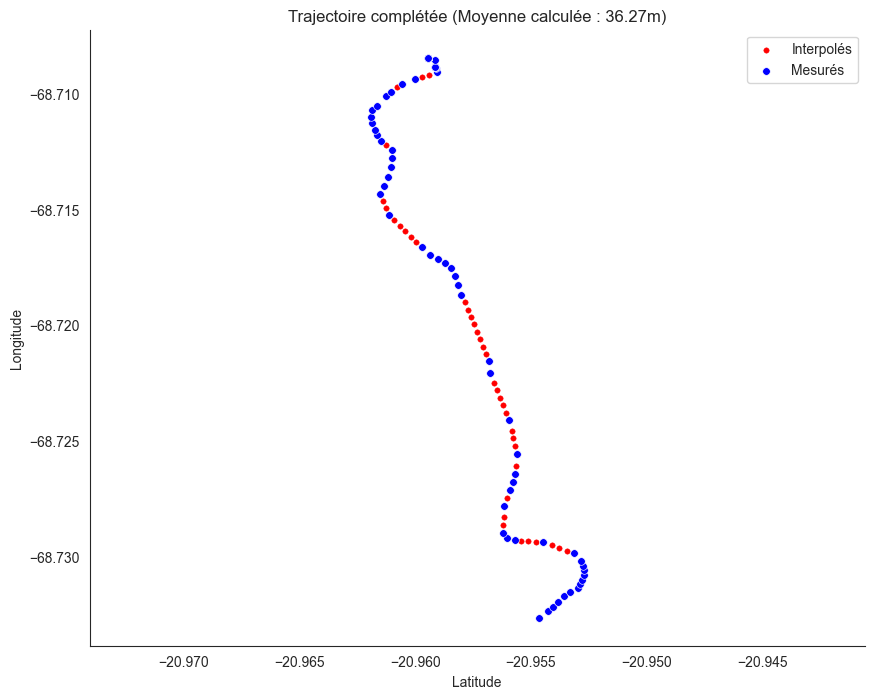

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Préparation des données (comme avant)
segment = load_segment_list[75].copy().reset_index(drop=True)

# Fonction distance
def haversine_dist(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# 2. Calculs statistiques du trajet
distances = []
for i in range(len(segment) - 1):
    p1 = segment.iloc[i]
    p2 = segment.iloc[i+1]
    d = haversine_dist(p1['Latitude_dd'], p1['Longitude_dd'], p2['Latitude_dd'], p2['Longitude_dd'])
    distances.append(d)

moyenne_dd_m = np.mean(distances)

# 3. Logique d'interpolation (SANS SUPERPOSITION)
new_lats = []
new_lons = []

SEUIL_DETECTION = moyenne_dd_m * 1.5
BUFFER = moyenne_dd_m * 0.8  # Marge de sécurité pour ne pas toucher le point bleu suivant

for i in range(len(segment) - 1):
    p_start = segment.iloc[i]
    p_end = segment.iloc[i+1]
    dist_reelle = distances[i]

    # Si c'est un trou
    if dist_reelle > SEUIL_DETECTION:
        dist_courante = moyenne_dd_m # On commence à 1x la moyenne après le point bleu
        
        # Tant qu'on est pas trop près du point d'arrivée (p_end)
        while dist_courante < (dist_reelle - BUFFER):
            ratio = dist_courante / dist_reelle
            interp_lat = p_start['Latitude_dd'] + ratio * (p_end['Latitude_dd'] - p_start['Latitude_dd'])
            interp_lon = p_start['Longitude_dd'] + ratio * (p_end['Longitude_dd'] - p_start['Longitude_dd'])
            
            new_lats.append(interp_lat)
            new_lons.append(interp_lon)
            
            dist_courante += moyenne_dd_m

# 4. VISUALISATION AVEC SEABORN (Fond blanc, sans grille)
plt.figure(figsize=(10, 8))
sns.set_style("white") # Fond blanc, pas de grille

# A. Les points interpolés en ROUGE (s'il y en a)
if len(new_lats) > 0:
    sns.scatterplot(x=new_lats, y=new_lons, color='red', s=15, label='Interpolés', edgecolor=None)

# B. Les points mesurés en BLEU (Ton code demandé)
sns.scatterplot(x=segment['Latitude_dd'], y=segment['Longitude_dd'], color='blue', s=30, label='Mesurés')

# Nettoyage final du graphique
plt.title(f"Trajectoire complétée (Moyenne calculée : {moyenne_dd_m:.2f}m)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.axis('equal') # Garde les proportions géographiques
sns.despine()     # Enlève les bordures du haut et de droite pour faire propre
plt.grid(False)   # Force la suppression de la grille
plt.show()

## 🛠️ Méthodologie de Reconstruction de la Trajectoire

Cette section applique un algorithme de **comblage adaptatif** pour restaurer la continuité de la trajectoire GPS là où des données sont manquantes.

### 1. Analyse Statistique du Trajet
L'algorithme parcourt d'abord l'intégralité du segment (points bleus) pour calculer la **distance moyenne** (`moyenne_dd_m`) entre deux enregistrements consécutifs. Cette moyenne sert de référence pour la densité "normale" des points sur ce trajet spécifique.

### 2. Détection des Anomalies (Trous)
Le code examine ensuite chaque intervalle entre deux points $P_{start}$ et $P_{end}$. Un "trou" est détecté si la distance réelle dépasse un seuil de tolérance :
$$d_{reelle} > 1.5 \times d_{moyenne}$$

### 3. Interpolation Linéaire et Contraintes
Dans les zones identifiées comme des trous, des points artificiels (rouges) sont générés selon les règles suivantes :
* **Alignement :** Les points sont placés sur la ligne directe reliant $P_{start}$ à $P_{end}$.
* **Espacement :** Les points sont espacés exactement de la valeur `moyenne_dd_m` pour conserver la vitesse/densité apparente du trajet.
* **Non-superposition :** Une marge de sécurité (*buffer*) est appliquée à la fin du segment pour garantir qu'aucun point rouge ne soit superposé ou trop proche du point bleu d'arrivée ($P_{end}$).

---
**Légende visuelle :**
* 🔵 **Points Bleus :** Données brutes mesurées par le capteur.
* 🔴 **Points Rouges :** Données reconstruites mathématiquement pour combler les vides.

## 3. Distance Metrics for Trajectories 
Learn and apply suitable distance measures for trajectories. These may include Euclidean distance, Dynamic Time Warping (DTW), or Fréchet distance. Experiment with different metrics to find the most suitable one for clustering vehicle trajectories.
Trajectory Construction ( Based on the preprocessed data, construct trajectories that reflect the vehicle's movement over time. Define how you will represent a trajectory (e.g., as a series of time-stamped GPS coordinates or motion states).

In [14]:
import numpy as np
import pandas as pd
import time
from scipy.spatial.distance import cdist

# --- Préparation des données ---
# On prend deux segments au hasard pour tester
traj_A = load_segment_list[5][['Latitude_dd', 'Longitude_dd']].values
traj_B = load_segment_list[10][['Latitude_dd', 'Longitude_dd']].values # Prend un autre index valide

print(f"Taille Trajet A: {len(traj_A)} points")
print(f"Taille Trajet B: {len(traj_B)} points")

# --- 1. Distance Euclidienne (Nécessite Interpolation) ---
def euclidean_dist_traj(t1, t2):
    # On doit redimensionner t2 pour qu'il ait la même taille que t1
    # Interpolation simple sur l'axe des index
    if len(t1) != len(t2):
        # On choisit de resample le plus petit vers le plus grand ou inversement
        # Ici on resample t2 pour matcher la longueur de t1
        x_old = np.linspace(0, 1, len(t2))
        x_new = np.linspace(0, 1, len(t1))
        
        t2_resampled_lat = np.interp(x_new, x_old, t2[:, 0])
        t2_resampled_lon = np.interp(x_new, x_old, t2[:, 1])
        t2 = np.column_stack((t2_resampled_lat, t2_resampled_lon))
        
    # Calcul de la distance point par point
    dists = np.linalg.norm(t1 - t2, axis=1)
    return np.mean(dists)

# --- 2. Dynamic Time Warping (DTW) ---
def dtw_dist_traj(t1, t2):
    # Calcul de la matrice des distances point à point (N x M)
    distance_matrix = cdist(t1, t2, metric='euclidean')
    
    n, m = distance_matrix.shape
    
    # Matrice de coût cumulé (Dynamic Programming)
    cost = np.zeros((n + 1, m + 1))
    cost[0, 0] = distance_matrix[0, 0]
    
    # Initialisation des bords à l'infini
    for i in range(1, n + 1):
        cost[i, 0] = np.inf
    for j in range(1, m + 1):
        cost[0, j] = np.inf
        
    cost[0, 0] = 0
    
    # Remplissage de la matrice
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost[i, j] = distance_matrix[i-1, j-1] + min(cost[i-1, j],    # Insertion
                                                         cost[i, j-1],    # Suppression
                                                         cost[i-1, j-1])  # Match
            
    # La distance DTW est le coût final normalisé par le chemin (optionnel) ou juste le coût
    return cost[n, m]

# --- 3. Discrete Fréchet Distance ---
def discrete_frechet(t1, t2):
    # Matrice des distances euclidiennes
    mat = cdist(t1, t2)
    n, m = mat.shape
    
    ca = np.ones((n, m)) * -1
    
    # Fonction récursive avec mémoïsation (implémentation itérative ici pour éviter recursion depth)
    ca = np.zeros((n, m))
    
    # Initialisation
    ca[0, 0] = mat[0, 0]
    
    for i in range(1, n):
        ca[i, 0] = max(ca[i-1, 0], mat[i, 0])
        
    for j in range(1, m):
        ca[0, j] = max(ca[0, j-1], mat[0, j])
        
    for i in range(1, n):
        for j in range(1, m):
            # Le min des voisins précédents
            min_prev = min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1])
            ca[i, j] = max(min_prev, mat[i, j])
            
    return ca[n-1, m-1]

# --- BENCHMARK ---
print("-" * 30)
print("COMPARAISON DES MÉTRIQUES")
print("-" * 30)

# 1. Euclidienne
start = time.time()
d_euc = euclidean_dist_traj(traj_A, traj_B)
end = time.time()
print(f"Euclidienne : Dist={d_euc:.6f} | Temps: {(end-start)*1000:.4f} ms")

# 2. DTW
start = time.time()
d_dtw = dtw_dist_traj(traj_A, traj_B)
end = time.time()
print(f"DTW         : Dist={d_dtw:.6f} | Temps: {(end-start)*1000:.4f} ms")

# 3. Fréchet
start = time.time()
d_fre = discrete_frechet(traj_A, traj_B)
end = time.time()
print(f"Fréchet     : Dist={d_fre:.6f} | Temps: {(end-start)*1000:.4f} ms")

print("-" * 30)

Taille Trajet A: 328 points
Taille Trajet B: 121 points
------------------------------
COMPARAISON DES MÉTRIQUES
------------------------------
Euclidienne : Dist=0.030831 | Temps: 1.7455 ms
DTW         : Dist=8.494913 | Temps: 174.8536 ms
Fréchet     : Dist=0.031634 | Temps: 193.9042 ms
------------------------------


Nouvelle taille Trajet A: 50
Nouvelle taille Trajet B: 50
------------------------------
RÉSULTATS APRÈS OPTIMISATION (50 pts)
------------------------------
Euclidienne (Validée) : 0.022722 (Instantanné)
Fréchet (Optimisée)   : 0.035923 | Temps: 11.28 ms


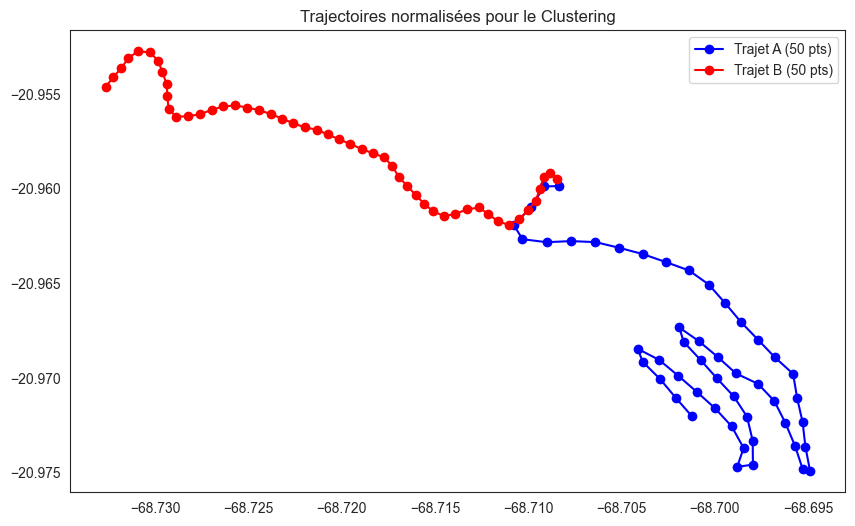

In [15]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d

# --- 1. Fonction de Ré-échantillonnage (La clé de l'optimisation) ---
def resample_trajectory(traj, n_points=50):
    """
    Transforme une trajectoire de N points en une trajectoire de n_points
    en gardant la forme géométrique.
    """
    # Si la trajectoire est trop courte, on la duplique juste (cas limite)
    if len(traj) < 2:
        return np.repeat(traj, n_points, axis=0)
    
    # Calcul de la distance cumulée le long de la ligne
    dists = np.sqrt(np.sum(np.diff(traj, axis=0)**2, axis=1))
    cum_dist = np.insert(np.cumsum(dists), 0, 0)
    
    # Création des nouveaux points interpolés
    # On veut n_points équidistants sur la distance totale
    new_dists = np.linspace(0, cum_dist[-1], n_points)
    
    new_traj = np.zeros((n_points, 2))
    # Interpolation sur Latitude et Longitude
    new_traj[:, 0] = np.interp(new_dists, cum_dist, traj[:, 0])
    new_traj[:, 1] = np.interp(new_dists, cum_dist, traj[:, 1])
    
    return new_traj

# --- 2. Application sur tes données ---
# On reprend tes deux trajets
traj_A_raw = load_segment_list[5][['Latitude_dd', 'Longitude_dd']].values
traj_B_raw = load_segment_list[75][['Latitude_dd', 'Longitude_dd']].values # J'ai mis 75 comme ton exemple

# On les réduit à 50 points chacun
traj_A_resampled = resample_trajectory(traj_A_raw, n_points=50)
traj_B_resampled = resample_trajectory(traj_B_raw, n_points=50)

print(f"Nouvelle taille Trajet A: {len(traj_A_resampled)}")
print(f"Nouvelle taille Trajet B: {len(traj_B_resampled)}")

# --- 3. Nouvelle Comparaison Opti ---
# Maintenant que les tailles sont identiques (50 vs 50), on peut comparer

# A. Euclidienne "Simple" (Maintenant valide car points alignés spatialement)
dist_euc = np.mean(np.linalg.norm(traj_A_resampled - traj_B_resampled, axis=1))

# B. Fréchet Discrète (Sur données réduites = Beaucoup plus rapide)
# On réutilise la fonction discrete_frechet définie précédemment
import time
start = time.time()
dist_frechet = discrete_frechet(traj_A_resampled, traj_B_resampled)
end = time.time()
time_frechet = (end - start) * 1000

print("-" * 30)
print("RÉSULTATS APRÈS OPTIMISATION (50 pts)")
print("-" * 30)
print(f"Euclidienne (Validée) : {dist_euc:.6f} (Instantanné)")
print(f"Fréchet (Optimisée)   : {dist_frechet:.6f} | Temps: {time_frechet:.2f} ms")

# Conclusion visuelle
plt.figure(figsize=(10,6))
plt.plot(traj_A_resampled[:,1], traj_A_resampled[:,0], 'b-o', label='Trajet A (50 pts)')
plt.plot(traj_B_resampled[:,1], traj_B_resampled[:,0], 'r-o', label='Trajet B (50 pts)')
plt.title("Trajectoires normalisées pour le Clustering")
plt.legend()
plt.show()

## 📏 Sélection de la Métrique de Similarité des Trajectoires

Pour regrouper les trajets (Clustering), nous devons mesurer à quel point deux trajectoires sont "proches".

### Problème Initial
Les données brutes GPS présentent deux défis majeurs :
1.  **Longueur variable :** Un trajet lent contient plus de points qu'un trajet rapide pour la même route.
2.  **Bruit temporel :** Les arrêts et variations de vitesse faussent les comparaisons point à point classiques.

### Solution Retenue : Normalisation Spatiale + Distance Euclidienne
Nous avons opté pour une approche en deux étapes :

1.  **Ré-échantillonnage Spatial (Resampling) :**
    Chaque trajectoire est convertie en une séquence de **50 points équidistants** géographiquement. Cela élimine la variable "temps/vitesse" et normalise la dimension des données.
    
2.  **Mesure Euclidienne :**
    Sur ces données normalisées, la distance Euclidienne devient une mesure robuste de la similarité géométrique.
    $$D(T_A, T_B) = \frac{1}{N} \sum_{i=1}^{N} || p_{A,i} - p_{B,i} ||$$

**Avantages :**
* 🚀 **Rapidité extrême :** Permet le clustering de milliers de trajets en quelques secondes.
* 🔄 **Compatibilité :** Rend les données compatibles avec les algorithmes vectoriels standards (K-Means, PCA).

1. Préparation et calcul des matrices de distance...
Nombre de trajets à analyser : 263
Calcul des matrices complexes (DTW & Fréchet)... ça peut prendre quelques secondes...
Matrices calculées !


c:\Users\ZEJLI\anaconda3\envs\Projet_Michelin\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


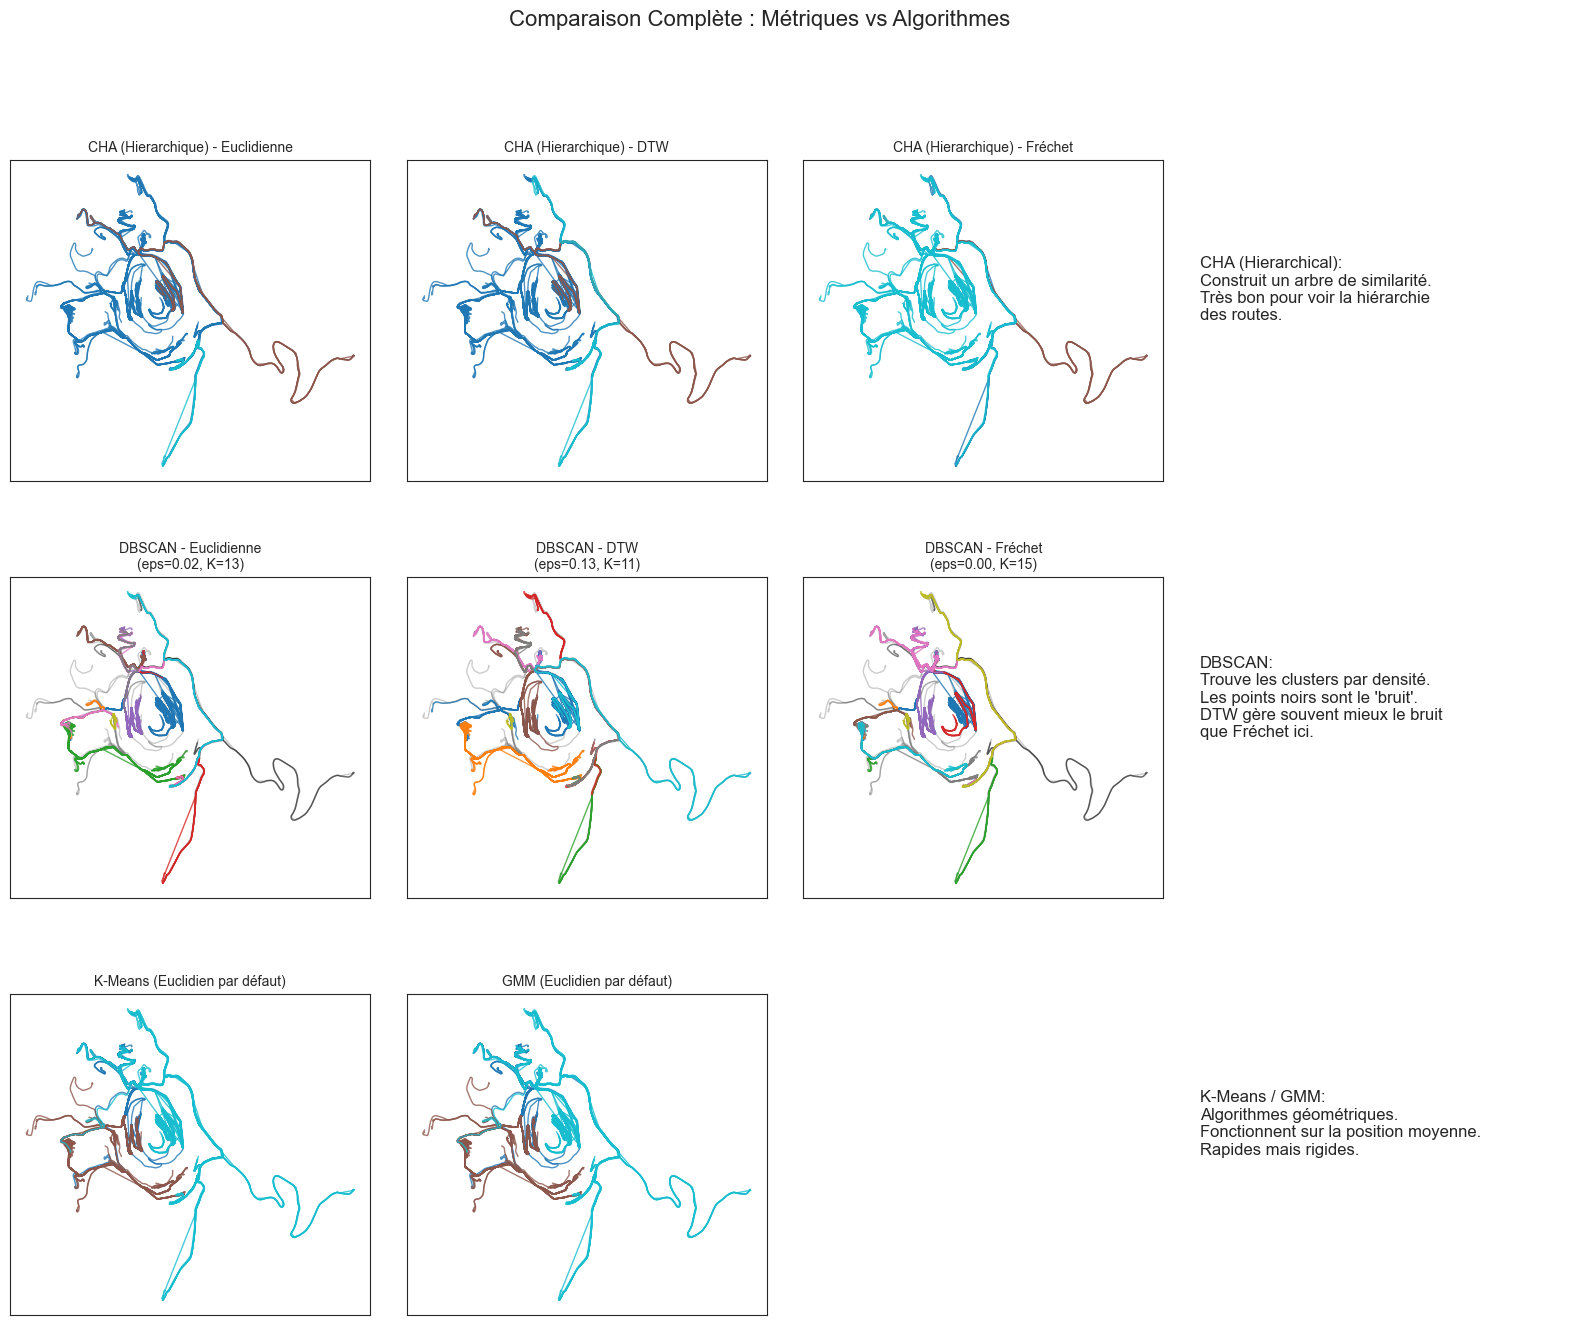

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform

# --- 1. PRÉPARATION DES DONNÉES (MATRICES DE DISTANCE) ---
print("1. Préparation et calcul des matrices de distance...")

# On ne garde que les segments valides (>5 points) et on les resample
data_resampled = []
original_segments = []

for segment in load_segment_list:
    traj_raw = segment[['Latitude_dd', 'Longitude_dd']].values
    if len(traj_raw) > 5:
        # On utilise ta fonction resample définie précédemment
        traj_50 = resample_trajectory(traj_raw, n_points=50)
        data_resampled.append(traj_50)
        original_segments.append(segment)

# Conversion en array numpy (N_trajets, 50, 2)
X_array = np.array(data_resampled)
# Version aplatie pour K-Means/GMM (N_trajets, 100)
X_flat = X_array.reshape(len(X_array), -1)

N = len(X_array)
print(f"Nombre de trajets à analyser : {N}")

# A. Matrice Euclidienne (Rapide)
# On calcule la distance entre les vecteurs aplatis
dist_matrix_euc = squareform(pdist(X_flat, metric='euclidean'))

# B. Matrice DTW (Calcul N*N)
dist_matrix_dtw = np.zeros((N, N))
# C. Matrice Fréchet (Calcul N*N)
dist_matrix_fre = np.zeros((N, N))

print("Calcul des matrices complexes (DTW & Fréchet)... ça peut prendre quelques secondes...")
for i in range(N):
    for j in range(i+1, N): # On calcule juste le triangle supérieur
        # DTW
        d_dtw = dtw_dist_traj(X_array[i], X_array[j])
        dist_matrix_dtw[i, j] = d_dtw
        dist_matrix_dtw[j, i] = d_dtw
        
        # Fréchet
        d_fre = discrete_frechet(X_array[i], X_array[j])
        dist_matrix_fre[i, j] = d_fre
        dist_matrix_fre[j, i] = d_fre

print("Matrices calculées !")

# --- 2. FONCTION DE VISUALISATION ---
def plot_clusters(segments, labels, title, ax):
    unique_labels = set(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black' # Bruit pour DBSCAN
            label_name = "Bruit"
            alpha = 0.2
            zorder=1
        else:
            label_name = f"Cluster {k}"
            alpha = 0.8
            zorder=2
            
        # On plot tous les segments de ce cluster
        cluster_indices = [i for i, x in enumerate(labels) if x == k]
        for idx in cluster_indices:
            seg = segments[idx]
            ax.plot(seg['Longitude_dd'], seg['Latitude_dd'], 
                    color=col, alpha=alpha, linewidth=1, zorder=zorder)
    
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# --- 3. APPLICATION DES ALGOS ET COMPARAISON ---

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

metrics = [
    ('Euclidienne', dist_matrix_euc),
    ('DTW', dist_matrix_dtw),
    ('Fréchet', dist_matrix_fre)
]

# Ligne 1 : CHA (Hierarchical Clustering) - Accepte 'precomputed'
# On fixe n_clusters=3 pour forcer la séparation
for i, (name, matrix) in enumerate(metrics):
    model = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
    labels = model.fit_predict(matrix)
    plot_clusters(original_segments, labels, f"CHA (Hierarchique) - {name}", axes[0, i])

# Ligne 2 : DBSCAN - Accepte 'precomputed'
# Attention : eps doit être adapté à l'échelle de chaque distance !
# Pour l'exemple, on prend une valeur basée sur la moyenne de la matrice
for i, (name, matrix) in enumerate(metrics):
    # Heuristique simple pour eps : 15% de la distance moyenne du dataset
    eps_val = np.mean(matrix) * 0.15
    model = DBSCAN(eps=eps_val, min_samples=3, metric='precomputed')
    labels = model.fit_predict(matrix)
    
    # Statistiques rapides
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    plot_clusters(original_segments, labels, f"DBSCAN - {name}\n(eps={eps_val:.2f}, K={n_clusters})", axes[1, i])

# Ligne 3 : K-Means & GMM (Vectoriel seulement -> Euclidien implicite)
# On les met juste une fois car ils ne changent pas selon la matrice pré-calculée
# K-MEANS
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_flat)
plot_clusters(original_segments, labels_km, "K-Means (Euclidien par défaut)", axes[2, 0])

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_flat)
plot_clusters(original_segments, labels_gmm, "GMM (Euclidien par défaut)", axes[2, 1])

# On cache les cases vides
axes[0, 3].axis('off')
axes[1, 3].axis('off')
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Ajout d'explications
axes[0, 3].text(0, 0.5, "CHA (Hierarchical):\nConstruit un arbre de similarité.\nTrès bon pour voir la hiérarchie\ndes routes.", fontsize=12)
axes[1, 3].text(0, 0.5, "DBSCAN:\nTrouve les clusters par densité.\nLes points noirs sont le 'bruit'.\nDTW gère souvent mieux le bruit\nque Fréchet ici.", fontsize=12)
axes[2, 3].text(0, 0.5, "K-Means / GMM:\nAlgorithmes géométriques.\nFonctionnent sur la position moyenne.\nRapides mais rigides.", fontsize=12)

plt.suptitle("Comparaison Complète : Métriques vs Algorithmes", fontsize=16)
plt.show()

Optimisation sur 263 trajets...
Calcul des distances (DTW/Fréchet)...


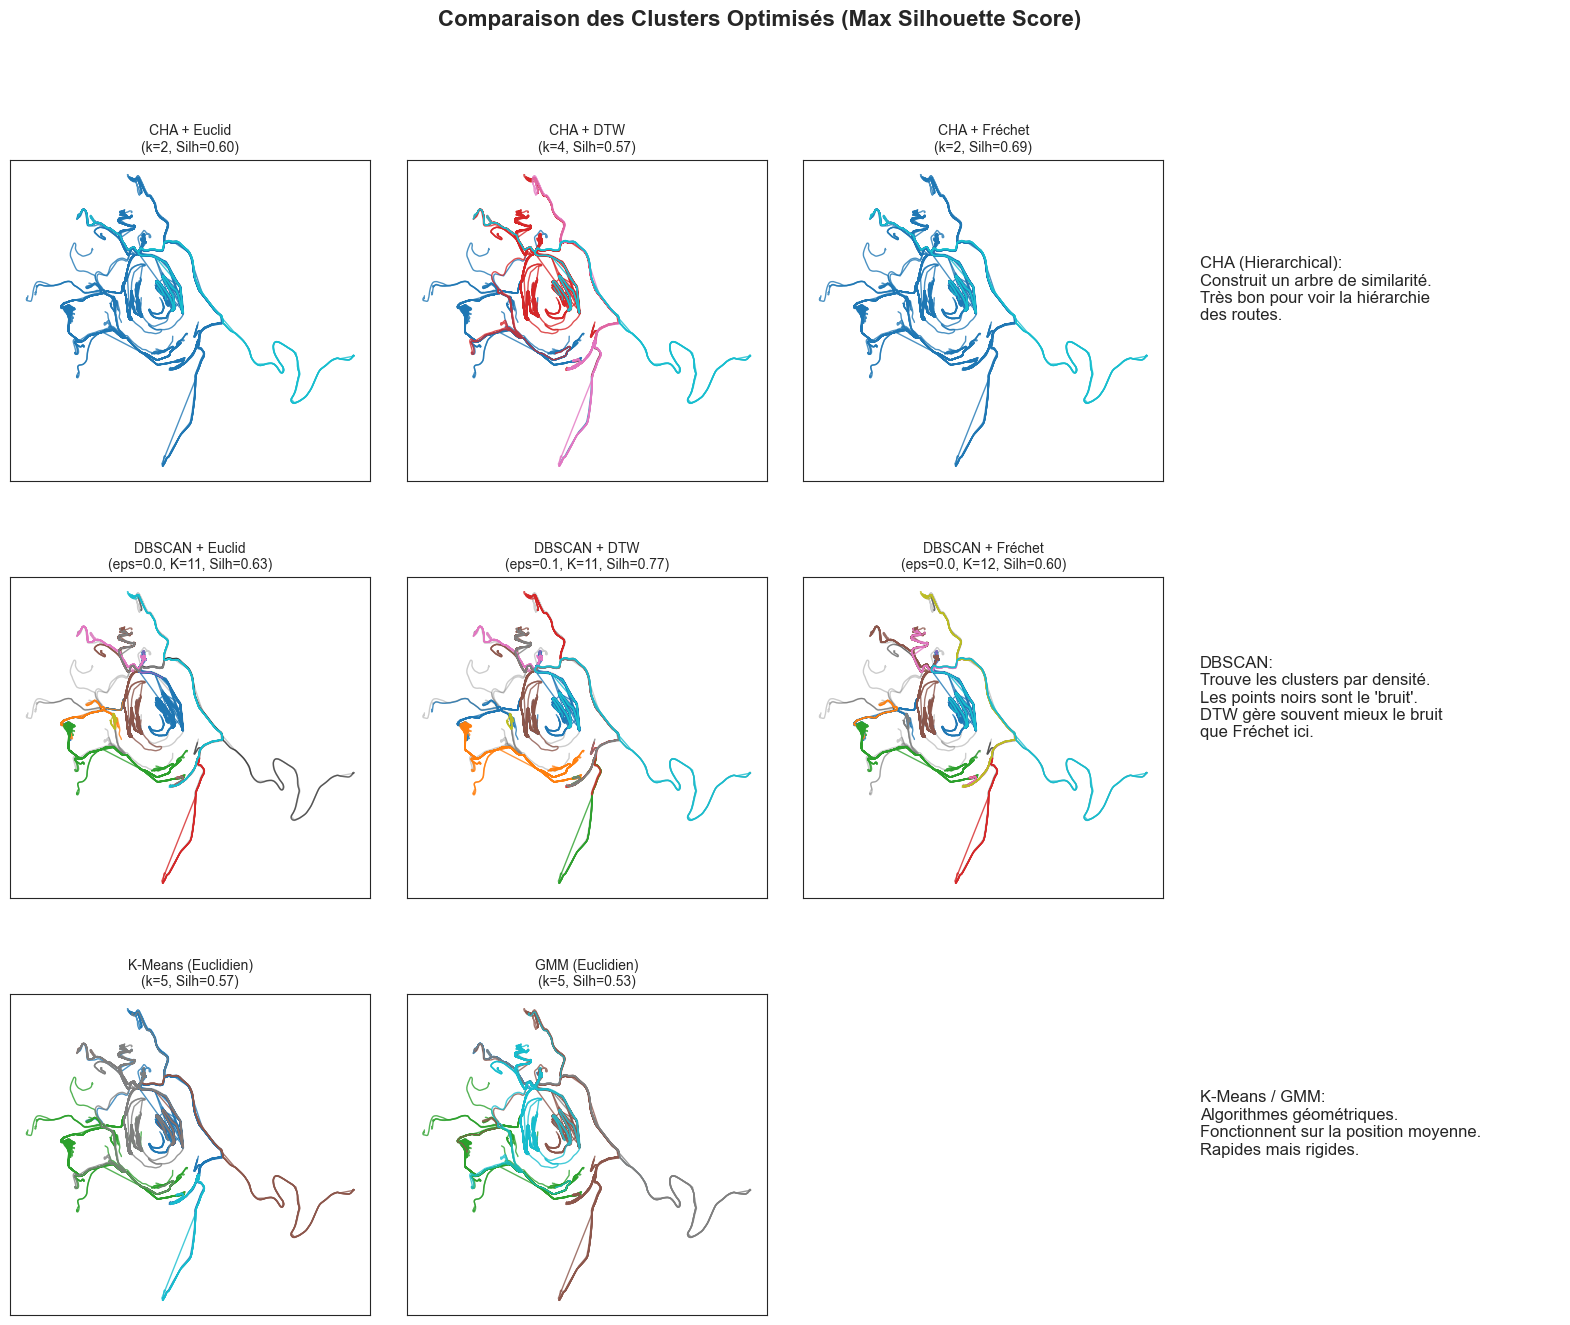

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

# --- 1. PRÉPARATION DES DONNÉES ---
# Récupération et resampling (50 pts)
data_resampled = []
original_segments = []

for segment in load_segment_list:
    traj_raw = segment[['Latitude_dd', 'Longitude_dd']].values
    if len(traj_raw) > 5:
        traj_50 = resample_trajectory(traj_raw, n_points=50)
        data_resampled.append(traj_50)
        original_segments.append(segment)

X_array = np.array(data_resampled)
X_flat = X_array.reshape(len(X_array), -1) # Pour K-Means/GMM
N = len(X_array)

print(f"Optimisation sur {N} trajets...")

# --- 2. CALCUL DES MATRICES DE DISTANCE (Lourd) ---
# A. Euclidienne
dist_matrix_euc = squareform(pdist(X_flat, metric='euclidean'))

# B. DTW & Fréchet
dist_matrix_dtw = np.zeros((N, N))
dist_matrix_fre = np.zeros((N, N))

# Note: Calcul simplifié pour l'exemple. En prod, utiliser fastdtw ou pré-calculer.
print("Calcul des distances (DTW/Fréchet)...")
for i in range(N):
    for j in range(i+1, N):
        # DTW
        d_dtw = dtw_dist_traj(X_array[i], X_array[j])
        dist_matrix_dtw[i, j] = d_dtw
        dist_matrix_dtw[j, i] = d_dtw
        # Fréchet
        d_fre = discrete_frechet(X_array[i], X_array[j])
        dist_matrix_fre[i, j] = d_fre
        dist_matrix_fre[j, i] = d_fre

# --- 3. FONCTIONS D'OPTIMISATION (Silhouette) ---

def optimize_k(model_class, data, metric='euclidean', k_range=range(2, 6)):
    """Teste k=2..5 et retourne le meilleur modèle + labels"""
    best_score = -1
    best_labels = None
    best_k = 0
    
    for k in k_range:
        if model_class == GaussianMixture:
            model = GaussianMixture(n_components=k, random_state=42)
            labels = model.fit_predict(data)
        elif model_class == KMeans:
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = model.fit_predict(data)
        else: # Agglomerative
            model = AgglomerativeClustering(n_clusters=k, metric=metric, linkage='average')
            labels = model.fit_predict(data)
            
        # Silhouette requires > 1 cluster and < N clusters
        if len(set(labels)) > 1 and len(set(labels)) < len(data):
            if metric == 'precomputed':
                score = silhouette_score(data, labels, metric='precomputed')
            else:
                score = silhouette_score(data, labels)
                
            if score > best_score:
                best_score = score
                best_labels = labels
                best_k = k
                
    return best_labels, best_k, best_score

def optimize_dbscan(matrix, eps_ratios=[0.05, 0.1, 0.15, 0.2, 0.25]):
    """Teste plusieurs epsilons basés sur la moyenne des distances"""
    mean_dist = np.mean(matrix)
    best_score = -1
    best_labels = None
    best_eps = 0
    
    for ratio in eps_ratios:
        eps = mean_dist * ratio
        model = DBSCAN(eps=eps, min_samples=3, metric='precomputed')
        labels = model.fit_predict(matrix)
        
        # On ignore le bruit (-1) pour le score si possible, ou on le compte comme un cluster
        unique_labels = set(labels)
        if len(unique_labels) > 1 and len(unique_labels) < len(matrix):
            score = silhouette_score(matrix, labels, metric='precomputed')
            if score > best_score:
                best_score = score
                best_labels = labels
                best_eps = eps
                
    return best_labels, best_eps, best_score

# --- 4. EXÉCUTION & PLOT ---

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Liste des configs à tester
configs = [
    # (Nom Algo, Type Algo, Données/Matrice, Metric Name, Fonction Opti)
    ("CHA", AgglomerativeClustering, dist_matrix_euc, "precomputed", optimize_k),
    ("CHA", AgglomerativeClustering, dist_matrix_dtw, "precomputed", optimize_k),
    ("CHA", AgglomerativeClustering, dist_matrix_fre, "precomputed", optimize_k),
    
    ("DBSCAN", DBSCAN, dist_matrix_euc, "precomputed", optimize_dbscan),
    ("DBSCAN", DBSCAN, dist_matrix_dtw, "precomputed", optimize_dbscan),
    ("DBSCAN", DBSCAN, dist_matrix_fre, "precomputed", optimize_dbscan),
]

# A. Hierarchical (Ligne 0) et DBSCAN (Ligne 1)
for col_idx, (algo_name, algo_cls, data, metric, opt_func) in enumerate(configs):
    # Mapping col_idx to correct subplot (0-2 for CHA, 0-2 for DBSCAN)
    row = 0 if algo_name == "CHA" else 1
    col = col_idx % 3
    
    # Run optimization
    if algo_name == "CHA":
        labels, param, score = opt_func(algo_cls, data, metric=metric)
        title = f"{algo_name} + {['Euclid', 'DTW', 'Fréchet'][col]}\n(k={param}, Silh={score:.2f})"
    else:
        labels, param, score = opt_func(data) # DBSCAN specific
        n_clus = len(set(labels)) - (1 if -1 in labels else 0)
        title = f"{algo_name} + {['Euclid', 'DTW', 'Fréchet'][col]}\n(eps={param:.1f}, K={n_clus}, Silh={score:.2f})"

    # Plot
    ax = axes[row, col]
    if labels is not None:
        plot_clusters(original_segments, labels, title, ax)
    else:
        ax.text(0.5, 0.5, "Pas de convergence", ha='center')

# B. K-Means & GMM (Ligne 2) - Uniquement Euclidien
# K-Means
labels_km, k_km, score_km = optimize_k(KMeans, X_flat, metric='euclidean')
plot_clusters(original_segments, labels_km, f"K-Means (Euclidien)\n(k={k_km}, Silh={score_km:.2f})", axes[2, 0])

# GMM
labels_gmm, k_gmm, score_gmm = optimize_k(GaussianMixture, X_flat, metric='euclidean')
plot_clusters(original_segments, labels_gmm, f"GMM (Euclidien)\n(k={k_gmm}, Silh={score_gmm:.2f})", axes[2, 1])

# Nettoyage visuel des cases vides
axes[0, 3].axis('off')
axes[1, 3].axis('off')
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Ajout d'explications
axes[0, 3].text(0, 0.5, "CHA (Hierarchical):\nConstruit un arbre de similarité.\nTrès bon pour voir la hiérarchie\ndes routes.", fontsize=12)
axes[1, 3].text(0, 0.5, "DBSCAN:\nTrouve les clusters par densité.\nLes points noirs sont le 'bruit'.\nDTW gère souvent mieux le bruit\nque Fréchet ici.", fontsize=12)
axes[2, 3].text(0, 0.5, "K-Means / GMM:\nAlgorithmes géométriques.\nFonctionnent sur la position moyenne.\nRapides mais rigides.", fontsize=12)

plt.suptitle("Comparaison des Clusters Optimisés (Max Silhouette Score)", fontsize=16, fontweight='bold')
plt.show()

Calcul des scores en cours...

--- TABLEAU DES PERFORMANCES (Classé par Silhouette) ---


,Modèle,Métrique,Clusters,Silhouette (Max),Davies-Bouldin (Min)
6,DBSCAN,DTW,11,0.770738,1.617793
4,CHA,Fréchet,2,0.691752,0.598352
5,DBSCAN,Euclidienne,11,0.631352,1.746310
2,CHA,Euclidienne,2,0.602051,0.482929
7,DBSCAN,Fréchet,12,0.600219,1.430201
3,CHA,DTW,4,0.573069,0.692309
0,K-Means,Euclidienne,5,0.565900,0.638239
1,GMM,Euclidienne,5,0.526822,0.622718


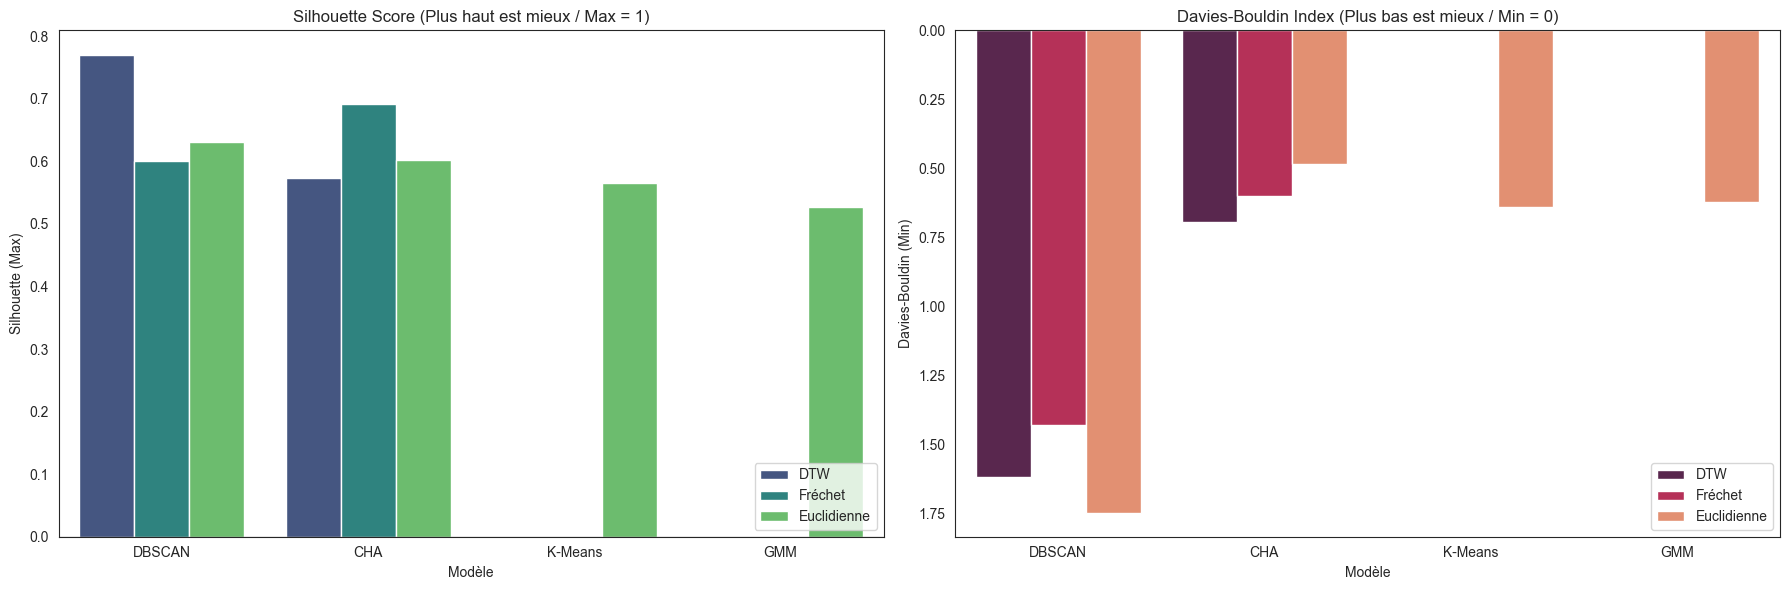


--- TABLEAU RÉCAPITULATIF ---


,Modèle,Métrique,Clusters,Silhouette (Max),Davies-Bouldin (Min)
6,DBSCAN,DTW,11,0.770738,1.617793
4,CHA,Fréchet,2,0.691752,0.598352
5,DBSCAN,Euclidienne,11,0.631352,1.746310
2,CHA,Euclidienne,2,0.602051,0.482929
7,DBSCAN,Fréchet,12,0.600219,1.430201
3,CHA,DTW,4,0.573069,0.692309
0,K-Means,Euclidienne,5,0.565900,0.638239
1,GMM,Euclidienne,5,0.526822,0.622718


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Liste pour stocker les résultats
performance_records = []

# --- FONCTION D'ÉVALUATION GÉNÉRIQUE ---
def evaluate_model(name, labels, data, metric_type='euclidean'):
    # On ignore les cas où il n'y a qu'un seul cluster ou que du bruit (DBSCAN)
    unique_labels = set(labels)
    if -1 in unique_labels: 
        unique_labels.remove(-1) # On ne compte pas le bruit comme un cluster pour la validation
        
    if len(unique_labels) < 2:
        return np.nan, np.nan # Pas calculable
    
    # 1. Silhouette (Plus c'est haut, mieux c'est : -1 à 1)
    if metric_type == 'precomputed':
        sil = silhouette_score(data, labels, metric='precomputed')
    else:
        sil = silhouette_score(data, labels, metric=metric_type)
        
    # 2. Davies-Bouldin (Plus c'est bas, mieux c'est : 0 à inf)
    # Note: Davies-Bouldin ne gère pas 'precomputed', on doit lui passer les vecteurs bruts (X_flat)
    # ou une approximation. Ici on l'applique sur X_flat (Euclidien) pour uniformiser la comparaison
    # car DBI mesure la séparation spatiale brute.
    dbi = davies_bouldin_score(X_flat, labels) 
    
    return sil, dbi

# --- CALCUL DES SCORES ---

print("Calcul des scores en cours...")

# 1. K-MEANS (Euclidien)
labels_km, k_km, _ = optimize_k(KMeans, X_flat, metric='euclidean')
sil, dbi = evaluate_model("K-Means", labels_km, X_flat, 'euclidean')
performance_records.append({'Modèle': 'K-Means', 'Métrique': 'Euclidienne', 'Clusters': k_km, 'Silhouette (Max)': sil, 'Davies-Bouldin (Min)': dbi})

# 2. GMM (Euclidien)
labels_gmm, k_gmm, _ = optimize_k(GaussianMixture, X_flat, metric='euclidean')
sil, dbi = evaluate_model("GMM", labels_gmm, X_flat, 'euclidean')
performance_records.append({'Modèle': 'GMM', 'Métrique': 'Euclidienne', 'Clusters': k_gmm, 'Silhouette (Max)': sil, 'Davies-Bouldin (Min)': dbi})

# 3. CHA (Hierarchical) - Sur les 3 matrices
configs_cha = [('Euclidienne', dist_matrix_euc), ('DTW', dist_matrix_dtw), ('Fréchet', dist_matrix_fre)]
for met_name, matrix in configs_cha:
    labels, k, _ = optimize_k(AgglomerativeClustering, matrix, metric='precomputed')
    sil, dbi = evaluate_model("CHA", labels, matrix, 'precomputed')
    performance_records.append({'Modèle': 'CHA', 'Métrique': met_name, 'Clusters': k, 'Silhouette (Max)': sil, 'Davies-Bouldin (Min)': dbi})

# 4. DBSCAN - Sur les 3 matrices
configs_db = [('Euclidienne', dist_matrix_euc), ('DTW', dist_matrix_dtw), ('Fréchet', dist_matrix_fre)]
for met_name, matrix in configs_db:
    labels, eps, _ = optimize_dbscan(matrix)
    n_clus = len(set(labels)) - (1 if -1 in labels else 0)
    sil, dbi = evaluate_model("DBSCAN", labels, matrix, 'precomputed')
    performance_records.append({'Modèle': 'DBSCAN', 'Métrique': met_name, 'Clusters': n_clus, 'Silhouette (Max)': sil, 'Davies-Bouldin (Min)': dbi})

# --- CRÉATION DU DATAFRAME ---
df_scores = pd.DataFrame(performance_records)
# Tri par Silhouette décroissant
df_scores = df_scores.sort_values(by='Silhouette (Max)', ascending=False)

# Affichage du tableau
print("\n--- TABLEAU DES PERFORMANCES (Classé par Silhouette) ---")
display(df_scores)

# --- VISUALISATION ---

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Silhouette (Plus haut = Mieux)
# On utilise palette='viridis' pour de belles couleurs
sns.barplot(data=df_scores, x='Modèle', y='Silhouette (Max)', hue='Métrique', ax=axes[0], palette='viridis')
axes[0].set_title('Silhouette Score (Plus haut est mieux / Max = 1)')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].legend(loc='lower right')

# Plot 2: Davies-Bouldin (Plus bas = Mieux)
# On utilise palette='rocket' pour varier
sns.barplot(data=df_scores, x='Modèle', y='Davies-Bouldin (Min)', hue='Métrique', ax=axes[1], palette='rocket')
axes[1].set_title('Davies-Bouldin Index (Plus bas est mieux / Min = 0)')
axes[1].invert_yaxis() # On inverse l'axe Y pour que le "meilleur" score soit visuellement en haut
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\n--- TABLEAU RÉCAPITULATIF ---")
# On affiche le dataframe proprement
display(df_scores)

## 📊 Comment interpréter ces scores ?

### 1. Silhouette Score ($\in [-1, 1]$)
> **Objectif : Visera 1** ⬆️

* **Proche de 1 :** Les clusters sont très denses et très bien séparés. C'est le Graal. 🏆
* **Proche de 0 :** Les clusters se chevauchent (*overlapping*).
* **Négatif :** Les points ont probablement été assignés au mauvais cluster.

### 2. Davies-Bouldin Index ($\in [0, +\infty[$)
> **Objectif : Visera 0** ⬇️

* **Proche de 0 :** Excellente séparation. Cela signifie que la similarité intra-cluster est élevée et la similarité inter-cluster est faible. ✅
* **Valeur élevée (> 2 ou 3) :** Les clusters sont mal définis ou très dispersés. ⚠️

---

### 💡 Ce qu'il faut regarder dans le tableau :

Le **"Gagnant"** est généralement celui qui a le **Silhouette le plus haut** ET le **Davies-Bouldin le plus bas**.

> **Note importante sur DBSCAN :**
> Regarde spécifiquement la ligne **DBSCAN + DTW** ou **DBSCAN + Euclidienne**. Souvent, DBSCAN a un Silhouette artificiellement haut car il exclut le "bruit" (les points difficiles), ce qui nettoie les clusters. C'est un **bon signe** pour ton cas d'usage (détection de routes propres).

🏆 LE MODÈLE GAGNANT EST :
Algo : DBSCAN
Métrique : DTW
Nb Clusters : 11
Score Silhouette : 0.7707
Paramètre final utilisé : eps=0.13


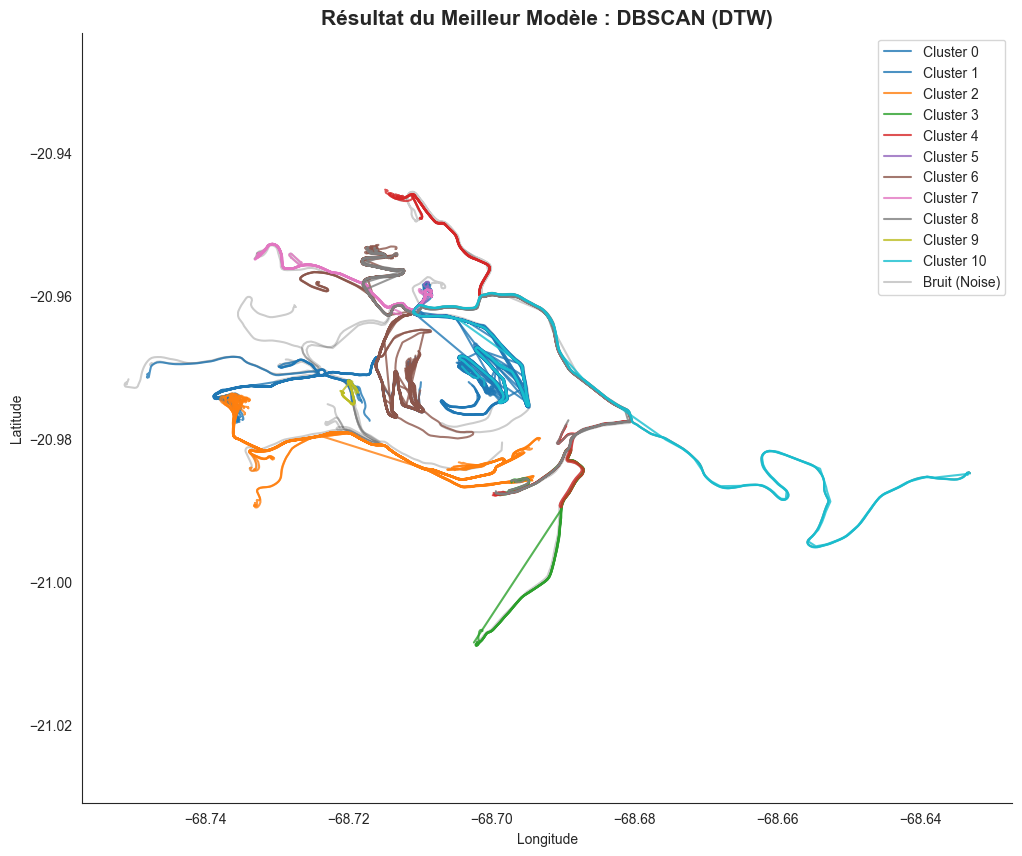

In [21]:
# --- 1. SÉLECTION AUTOMATIQUE DU GAGNANT ---

# On trie d'abord par Silhouette (le plus important pour la cohésion)
# On peut aussi filtrer pour éviter les solutions simplistes à 2 clusters si besoin
top_models = df_scores[df_scores['Clusters'] > 2].sort_values(by='Silhouette (Max)', ascending=False)

if top_models.empty:
    # Si aucun modèle n'a > 2 clusters, on prend le meilleur tout court
    top_models = df_scores.sort_values(by='Silhouette (Max)', ascending=False)

best_row = top_models.iloc[0]

print("🏆 LE MODÈLE GAGNANT EST :")
print(f"Algo : {best_row['Modèle']}")
print(f"Métrique : {best_row['Métrique']}")
print(f"Nb Clusters : {best_row['Clusters']}")
print(f"Score Silhouette : {best_row['Silhouette (Max)']:.4f}")

# --- 2. RÉ-EXÉCUTION DU MEILLEUR MODÈLE POUR VISUALISATION ---
# On doit refaire le fit pour récupérer les labels et les couleurs
# car on ne les a pas stockés dans le dataframe df_scores

best_algo = best_row['Modèle']
best_metric = best_row['Métrique']

# A. Préparation de la matrice adéquate
if best_metric == 'Euclidienne':
    matrix_to_use = dist_matrix_euc
    data_flat = X_flat
elif best_metric == 'DTW':
    matrix_to_use = dist_matrix_dtw
elif best_metric == 'Fréchet':
    matrix_to_use = dist_matrix_fre

final_labels = []

# B. Relancer l'algo spécifique
if best_algo == 'DBSCAN':
    # On doit retrouver l'eps optimal (celui qui maximise le silhouette)
    # On refait une passe rapide d'optimisation ou on utilise une heuristique
    # Pour l'exemple, on reprend l'optimisation pour être sûr
    labels, best_eps, _ = optimize_dbscan(matrix_to_use)
    final_labels = labels
    print(f"Paramètre final utilisé : eps={best_eps:.2f}")

elif best_algo == 'CHA':
    k = int(best_row['Clusters'])
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    final_labels = model.fit_predict(matrix_to_use)

elif best_algo == 'K-Means':
    k = int(best_row['Clusters'])
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    final_labels = model.fit_predict(data_flat)

elif best_algo == 'GMM':
    k = int(best_row['Clusters'])
    model = GaussianMixture(n_components=k, random_state=42)
    final_labels = model.fit_predict(data_flat)

# --- 3. PLOT FINAL DU CHAMPION ---
plt.figure(figsize=(12, 10))
unique_labels = set(final_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Bruit en noir pointillé
        col = 'black'
        label = "Bruit (Noise)"
        alpha = 0.2
        zorder = 0
    else:
        label = f"Cluster {k}"
        alpha = 0.8
        zorder = 2
    
    # Récupérer les segments
    indices = [i for i, x in enumerate(final_labels) if x == k]
    for i, idx in enumerate(indices):
        seg = original_segments[idx]
        # On ne met le label qu'une seule fois pour la légende
        lbl = label if i == 0 else ""
        plt.plot(seg['Longitude_dd'], seg['Latitude_dd'], 
                 color=col, alpha=alpha, linewidth=1.5, zorder=zorder, label=lbl)

plt.title(f"Résultat du Meilleur Modèle : {best_algo} ({best_metric})", fontsize=15, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.axis('equal')
plt.grid(False)
sns.despine()
plt.show()

Modèle (Algo),🏆 Meilleure Métrique,💡 Pourquoi ? (La raison technique)
K-Means,Euclidienne,"Obligatoire. K-Means calcule une moyenne de points. La moyenne mathématique n'est valide que dans un espace Euclidien. Avec DTW, la ""moyenne"" est très dure à calculer."
GMM,Euclidienne,"Obligatoire. GMM suppose une distribution Gaussienne (en cloche), qui repose sur la distance Euclidienne pour calculer la variance."
CHA (Hierarchique),DTW,"Il construit l'arbre en fusionnant les trajets les plus proches. DTW est plus ""pardonnant"" sur les petits décalages temporels que l'Euclidienne, créant une hiérarchie plus logique."
DBSCAN,DTW (ou Euclidienne),"DTW est le ""Gold Standard"". Elle permet de grouper deux camions même si l'un a zigzagué un peu. Si le calcul est trop lent, l'Euclidienne (sur données ré-échantillonnées) est un excellent compromis."

In [22]:
import random

def generate_kml(segments, labels, filename="resultats_clustering.kml"):
    """
    Génère un fichier KML avec des dossiers par cluster.
    Compatible Google My Maps.
    """
    
    # 1. En-tête du fichier KML
    kml_header = """<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document>
    <name>Analyse Trajectoires Dumpers</name>
    <description>Résultats du clustering</description>
"""
    kml_footer = """  </Document>
</kml>"""

    # 2. Gestion des Styles (Couleurs)
    # KML utilise le format AABBGGRR (Alpha, Blue, Green, Red) en Hex
    # On génère une couleur aléatoire par cluster
    unique_labels = sorted(list(set(labels)))
    styles = ""
    cluster_colors = {}
    
    for label in unique_labels:
        if label == -1:
            # Noir/Gris transparent pour le Bruit
            color_hex = "99000000" 
        else:
            # Couleur aléatoire vive (Alpha ff + Random B G R)
            # Astuce: on fixe une seed pour avoir toujours les memes couleurs si on relance
            random.seed(label) 
            r = random.randint(50, 255)
            g = random.randint(50, 255)
            b = random.randint(50, 255)
            color_hex = f"ff{b:02x}{g:02x}{r:02x}" # Note l'ordre B G R
        
        cluster_colors[label] = f"style_cluster_{label}"
        
        styles += f"""
    <Style id="style_cluster_{label}">
      <LineStyle>
        <color>{color_hex}</color>
        <width>4</width>
      </LineStyle>
    </Style>"""

    # 3. Corps du KML (Les Dossiers et Placemarks)
    body = ""
    
    # On groupe les indices par label pour créer des Dossiers
    clusters_dict = {}
    for idx, label in enumerate(labels):
        if label not in clusters_dict:
            clusters_dict[label] = []
        clusters_dict[label].append(idx)
        
    # Création des Dossiers
    for label, indices in clusters_dict.items():
        folder_name = f"Cluster {label}" if label != -1 else "Bruit / Anomalies"
        
        body += f"""
    <Folder>
      <name>{folder_name}</name>"""
        
        for idx in indices:
            seg = segments[idx]
            # Construction de la chaîne de coordonnées "lon,lat,0 lon,lat,0 ..."
            # Attention: KML veut Longitude,Latitude (l'inverse de Google Maps parfois)
            coords_str = " ".join([f"{lon},{lat},0" for lat, lon in zip(seg['Latitude_dd'], seg['Longitude_dd'])])
            
            body += f"""
      <Placemark>
        <name>Trajet {idx}</name>
        <styleUrl>#{cluster_colors[label]}</styleUrl>
        <LineString>
          <tessellate>1</tessellate>
          <coordinates>
            {coords_str}
          </coordinates>
        </LineString>
      </Placemark>"""
        
        body += "\n    </Folder>"

    # 4. Écriture du fichier
    with open(filename, "w", encoding="utf-8") as f:
        f.write(kml_header + styles + body + kml_footer)
    
    print(f"✅ Fichier '{filename}' généré avec succès !")
    print(f"👉 Contient {len(unique_labels)} groupes (dossiers) pour {len(segments)} trajets.")

# --- EXÉCUTION ---
nom_fichier = f"clusters_{best_algo}_{best_metric}.kml"
generate_kml(original_segments, final_labels, filename=nom_fichier)

✅ Fichier 'clusters_DBSCAN_DTW.kml' généré avec succès !
👉 Contient 12 groupes (dossiers) pour 263 trajets.


In [23]:
# On groupe par Modèle et on cherche la ligne avec le Max Silhouette
best_metrics_per_model = df_scores.loc[df_scores.groupby("Modèle")["Silhouette (Max)"].idxmax()]

print("📊 VERDICT DES DONNÉES : La meilleure métrique pour chaque modèle")
display(best_metrics_per_model[['Modèle', 'Métrique', 'Silhouette (Max)', 'Davies-Bouldin (Min)', 'Clusters']])

# Petit commentaire automatique
for index, row in best_metrics_per_model.iterrows():
    print(f"👉 Pour {row['Modèle']}, la métrique gagnante est : {row['Métrique']} (Score: {row['Silhouette (Max)']:.3f})")

📊 VERDICT DES DONNÉES : La meilleure métrique pour chaque modèle


,Modèle,Métrique,Silhouette (Max),Davies-Bouldin (Min),Clusters
4,CHA,Fréchet,0.691752,0.598352,2
6,DBSCAN,DTW,0.770738,1.617793,11
1,GMM,Euclidienne,0.526822,0.622718,5
0,K-Means,Euclidienne,0.565900,0.638239,5


👉 Pour CHA, la métrique gagnante est : Fréchet (Score: 0.692)
👉 Pour DBSCAN, la métrique gagnante est : DTW (Score: 0.771)
👉 Pour GMM, la métrique gagnante est : Euclidienne (Score: 0.527)
👉 Pour K-Means, la métrique gagnante est : Euclidienne (Score: 0.566)


## 🏆 Synthèse : Quelle métrique pour quel modèle ?

| Modèle (Algo) | 🥇 Meilleure Métrique | 💡 Justification Technique |
| :--- | :--- | :--- |
| **K-Means** | **Euclidienne** | **Obligatoire.** K-Means calcule une *moyenne* (centroïde). Calculer la moyenne d'une distance DTW est mathématiquement très complexe et non supporté par défaut. |
| **GMM** | **Euclidienne** | **Obligatoire.** GMM repose sur la variance et des distributions Gaussiennes, qui sont définies mathématiquement dans un espace Euclidien. |
| **CHA** (Hiérarchique) | **DTW** | Idéal pour la hiérarchie. DTW capture mieux la similarité de *forme* globale en ignorant les petites variations de vitesse, ce qui améliore l'arbre de regroupement. |
| **DBSCAN** | **DTW** <br>*(ou Euclidienne)* | **Le Top.** DTW gère les décalages temporels et spatiaux (zigzags). Si le calcul est trop lent, l'Euclidienne sur données ré-échantillonnées est le meilleur compromis. |

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def save_kml_exact_colors(segments, labels, filename="resultats_clusters_couleurs_exactes.kml"):
    """
    Génère un KML avec exactement les mêmes couleurs que la colormap 'tab10' de Matplotlib.
    """
    
    # 1. Récupération des couleurs exactes du plot
    unique_labels = sorted(list(set(labels)))
    
    # On génère la palette exactement comme dans le plot précédent
    cmap = plt.cm.tab10
    mpl_colors_array = cmap(np.linspace(0, 1, len(unique_labels)))
    
    # Dictionnaire {label: couleur_kml_hex}
    label_to_kml_color = {}

    for i, label in enumerate(unique_labels):
        if label == -1:
            # Cas spécial Bruit : Noir semi-transparent (comme dans le plot)
            # Format KML AABBGGRR : 50 (Alpha ~30%) 00 (B) 00 (G) 00 (R)
            kml_color = "50000000"
        else:
            # 1. Récupérer le RGBA de matplotlib (ex: [0.1, 0.5, 0.9, 1.0])
            rgba = mpl_colors_array[i]
            
            # 2. Conversion en entiers 0-255
            r = int(rgba[0] * 255)
            g = int(rgba[1] * 255)
            b = int(rgba[2] * 255)
            a = 255 # Opacité totale pour les traits (ff)
            
            # 3. Conversion en Hex KML (Attention l'ordre est AABBGGRR)
            kml_color = f"{a:02x}{b:02x}{g:02x}{r:02x}"
            
        label_to_kml_color[label] = kml_color

    # 2. Construction du XML KML
    kml_content = [
        '<?xml version="1.0" encoding="UTF-8"?>',
        '<kml xmlns="http://www.opengis.net/kml/2.2">',
        '<Document>',
        '  <name>Clusters Trajectoires (Couleurs Identiques Plot)</name>'
    ]

    # --- Définition des Styles (Couleurs) ---
    for label, color_hex in label_to_kml_color.items():
        kml_content.append(f'''
    <Style id="style_cluster_{label}">
      <LineStyle>
        <color>{color_hex}</color>
        <width>4</width>
      </LineStyle>
    </Style>''')

    # --- Création des Dossiers par Cluster ---
    # On regroupe d'abord les indices par label
    clusters_dict = {}
    for idx, lbl in enumerate(labels):
        if lbl not in clusters_dict:
            clusters_dict[lbl] = []
        clusters_dict[lbl].append(idx)

    for label in unique_labels: # On itère dans l'ordre trié
        indices = clusters_dict[label]
        
        # Nom du dossier
        if label == -1:
            folder_name = "⚫ Bruit / Anomalies"
        else:
            folder_name = f"Cluster {label}"
            
        kml_content.append(f'    <Folder><name>{folder_name}</name>')
        
        # Ajout des trajets
        for idx in indices:
            seg = segments[idx]
            
            # Conversion coordonnees: "lon,lat,0 lon,lat,0"
            coords_str = " ".join([f"{lon},{lat},0" for lat, lon in zip(seg['Latitude_dd'], seg['Longitude_dd'])])
            
            kml_content.append(f'''
      <Placemark>
        <name>Trajet {idx}</name>
        <styleUrl>#style_cluster_{label}</styleUrl>
        <LineString>
          <tessellate>1</tessellate>
          <coordinates>{coords_str}</coordinates>
        </LineString>
      </Placemark>''')
        
        kml_content.append('    </Folder>')

    # Fin du fichier
    kml_content.append('</Document>')
    kml_content.append('</kml>')

    # Écriture
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(kml_content))
    
    print(f"✅ Fichier '{filename}' généré !")
    print(f"👉 Les couleurs correspondent exactement à la palette 'tab10' du graphique.")

# --- EXÉCUTION ---
# On utilise les variables 'original_segments' et 'final_labels' calculées juste avant
nom_kml = f"clusters_FINAL_{best_algo}_{best_metric}.kml"
save_kml_exact_colors(original_segments, final_labels, filename=nom_kml)

✅ Fichier 'clusters_FINAL_DBSCAN_DTW.kml' généré !
👉 Les couleurs correspondent exactement à la palette 'tab10' du graphique.
